## 3. Implement linear regression from scratch

0. Simulate phone dataset (*)

We want to simulate data (x,y) to represent cost for phone subscriptions, with:

- X called minutes per month
- y SEK per month

  a) Use numpy.random.normal() to simulate a dataset with the following requirements:(*)

- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v.   X ~ N (100,100)
- take absolute value of these x-values
- simulate noise 400 noise values from r.v.   e ~ N (0.50)
- Let y = 2x + 25 + e 
- plot the data set

In [241]:
# Set seed to 42
import numpy as np
np.random.seed(42)

#- simulate 400 x-values from the r.v.   X ~ N (100,100) 400 samples
x = np.random.normal(loc=100, scale=100, size=400)

# - take absolute value of these x-values (ta positiva tal)
x = np.abs(x)

# - simulate noise 400 noise values from r.v.   e ~ N (0.50) epsilon = e. Vad är e? 
e = np.random.normal(loc=0, scale=50, size=400)

# - Let y = 2x + 25 + e 
y = 2 * x + 25 + e

In [242]:
x.min()

np.float64(0.25293646378088397)

<Axes: >

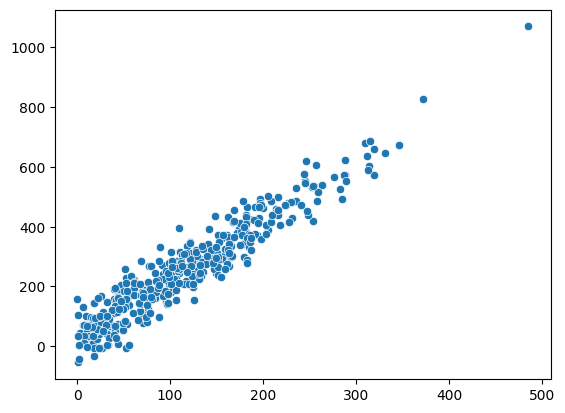

In [243]:
# plot the data set
import seaborn as sns

sns.scatterplot(x=x, y=y)

 b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\\beta_0 = 25, \\beta_1 = 2

- X called minutes per month
- y SEK per month

In [244]:
x.min(),y.min()

(np.float64(0.25293646378088397), np.float64(-54.484386920295805))

In [245]:
# x = x[x <= 300]
# y=np.abs(y)
# y = y[:389]

# # - no one talks more than 300 min using this type of subscription
# # - no ones costs can be negative

mask = x <= 300
x=x[mask]
y=y[mask]
y=np.abs(y)
len(x), len(y)

(389, 389)

<Axes: >

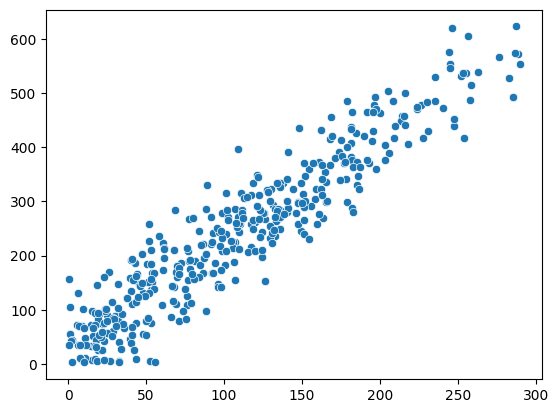

In [246]:

# - plot the new dataset

sns.scatterplot(x=x,y=y)


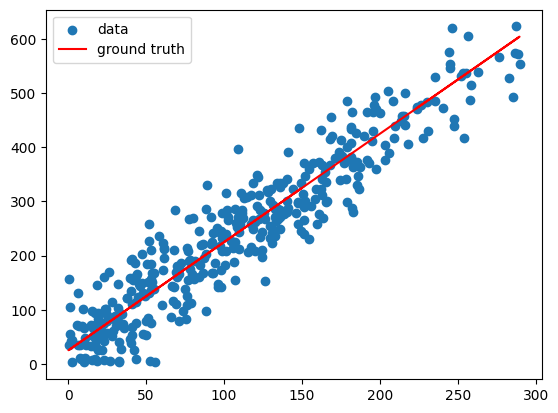

In [247]:
# - also plot ground truth using the true parameters $\\beta_0 = 25, \\beta_1 = 2
beta_0 = 25
beta_1 = 2
y_true = beta_0 + beta_1 * x
import matplotlib.pyplot as plt
plt.scatter(x=x,y=y, label="data")
plt.plot(x, y_true, color="red", label="ground truth")
plt.legend()
plt.show()

In [248]:
#  c) Insert the values into a DataFrame (*
import pandas as pd
phone_data = {
    "Minutes": x,
    "Cost": y
}
df = pd.DataFrame(phone_data)
df

,Minutes,Cost
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051
...,...,...
384,53.082435,183.822512
385,71.313453,165.649148
386,235.387237,529.849510
387,88.546015,203.507950


# train|test split

  a) Create a train-test-split function with the following call signature: (*)
```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple

that returns the tuple:

(X_train, X_test, y_train, y_test)
```

In [249]:
def train_test_split(
    X: pd.DataFrame, 
    y: pd.DataFrame, 
    train_fraction: float = 0.7, 
    random_state: int = 42, 
    replace: bool = False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    np.random.seed(random_state) # 42
    n = len(x) #398
    
    indices = np.arange(n) # numpy.ndarray
    
    # Välj slumpmässigt från train indices
    # Ta 70 % av datan och gör det till train-data
    train_size = int(n * train_fraction) # n* 0.7
    train_indices = np.random.choice(indices, size=train_size, replace=replace) #ndarray, n* 0.7, False
    
    # Resten blir test-data. setdiff1d = Find the set difference of two arrays.
    test_indices = np.setdiff1d(indices, train_indices)
    
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test

X = pd.DataFrame(x)
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272, 1), (117, 1), (272, 1), (117, 1))

In [250]:
# Check the length of each set, and check the indices of the sorted sets that they don't overlap and are not missing. Also check that they sum up to what you expect.
X_test[:3],y_test[:3]

(            0
 1   86.173570
 8   53.052561
 13  91.328024,
              0
 1   167.378389
 8   137.119904
 13  271.539890)

In [251]:
X_train[:3],y_train[:3]

(              0
 271  106.980208
 46    53.936123
 167   24.626384,
               0
 271  285.744337
 46   151.202158
 167   56.677093)

In [252]:
sum(X_train[0].shape + X_test[0].shape)

389

In [253]:
overlap_X = np.intersect1d(X_train, X_test)
overlap_y = np.intersect1d(y_train, y_test)
len(overlap_X), len(overlap_y)

(0, 0)

2. Simple linear regression with normal equation (*)

Use the normal equation for simple linear regression to solve for the coefficients b^ = (b0, b1) (y = kx + m). Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data.
- Hint

    It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy.

In [254]:
def linear_regression(X_train, y_train):
#beräkna k (lutningen)
    k = np.sum((X_train - X_train.mean()) * (y_train - y_train.mean())) / np.sum((X_train - X_train.mean()) **2)

    #Beräkna m (skärningspunkten)
    m = y_train.mean() - k * X_train.mean()

    # Skapa linje för prediktioner
    X_line = np.linspace(X_train.min(), X_train.max(), num=100) #jämt fördelade x-värden num=number of samples generated    array([[2.52936464e-01],[3.17643507e+00],[6.09993367e+00],[9.02343228e+00]

    k = float(k)
    m = float(m)

    #regression line
    y_pred = m + k * X_line

    #ground truth (om du vet ekvationen)
    y_true = 25 + 2 * X_line
    
    print("(intercept) m =", m)
    print("(slope) k =", k)
    return m, k, y_pred, y_true, X_line

# Fit modellen på träningsdata
m, k, y_pred, y_true, X_line = linear_regression(X_train, y_train)

(intercept) m = 32.830197471001185
(slope) k = 1.8988339087630484


c:\Users\Lukas\VSCode\ai_engineering_natali_harju\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Lukas\AppData\Local\Temp\ipykernel_19144\830331182.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  k = float(k)
C:\Users\Lukas\AppData\Local\Temp\ipykernel_19144\830331182.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  m = float(m)


In [255]:
print(m, k)
type(m), type(k)

32.830197471001185 1.8988339087630484


(float, float)

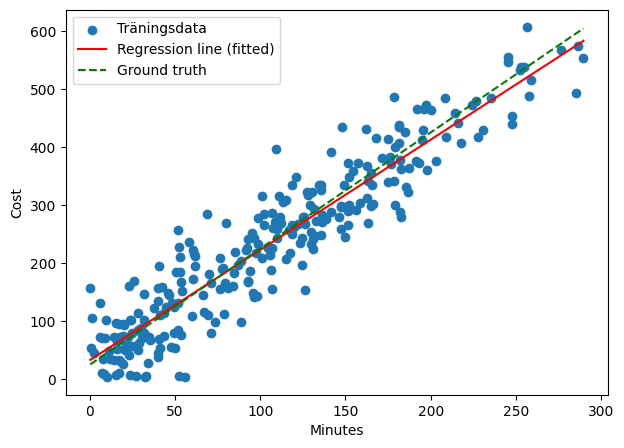

In [256]:


# Plotta

plt.figure(figsize=(7,5))
plt.scatter(X_train, y_train, label="Träningsdata")
plt.plot(X_line, y_pred, color="red", label="Regression line (fitted)")
plt.plot(X_line, y_true, color="green", linestyle="--", label="Ground truth")
plt.xlabel("Minutes")
plt.ylabel("Cost")
plt.legend()

## 3. Prediction and evaluation (*)

  a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

  b) Calculate MAE, MSE, RMSE (*)


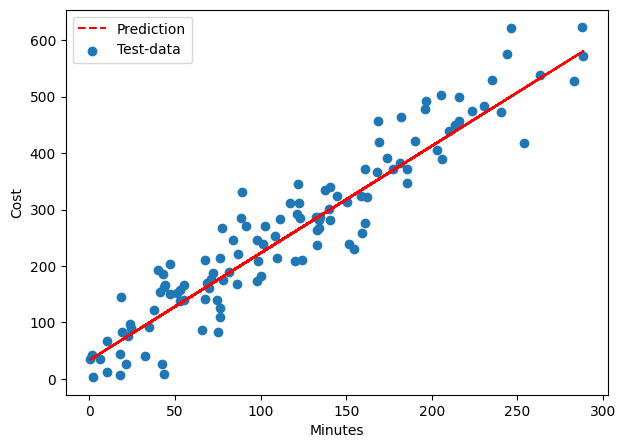

In [257]:
#   a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)
y_pred = m + k * X_test
# y-pred mot x_test, och y_test mot X_test
plt.figure(figsize=(7,5))
plt.plot(X_test, y_pred, color="red", linestyle="--", label="Prediction")
plt.scatter(x=X_test, y=y_test, label="Test-data")
plt.xlabel("Minutes")
plt.ylabel("Cost")
plt.legend()

In [258]:
#   b) Calculate MAE, MSE, RMSE (*)
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred) **2)
rmse = np.sqrt(mse)
mae, mse, rmse

(np.float64(38.710788664662175),
 np.float64(2430.953187870168),
 np.float64(49.30469742195127))